In [1]:
import torch

from unet import UNet
from dataset import SegmentationDataset, DataLoader
from plot import show_sample

## Load Dataset 
Describe image and mask showing max and min values

In [2]:
image_dir = '../datasets/Brain_tumor_segmentation/manual_test'
mask_dir = '../datasets/Brain_tumor_segmentation/manual_test_masks'
dataset = SegmentationDataset(image_dir, mask_dir)

In [3]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
image, mask = next(iter(dataloader))
print("Image min/max:", image.min().item(), image.max().item())
print("Máscara min/max:", mask.min().item(), mask.max().item())

Image min/max: 0.0 0.9137254953384399
Máscara min/max: 0.0 1.0


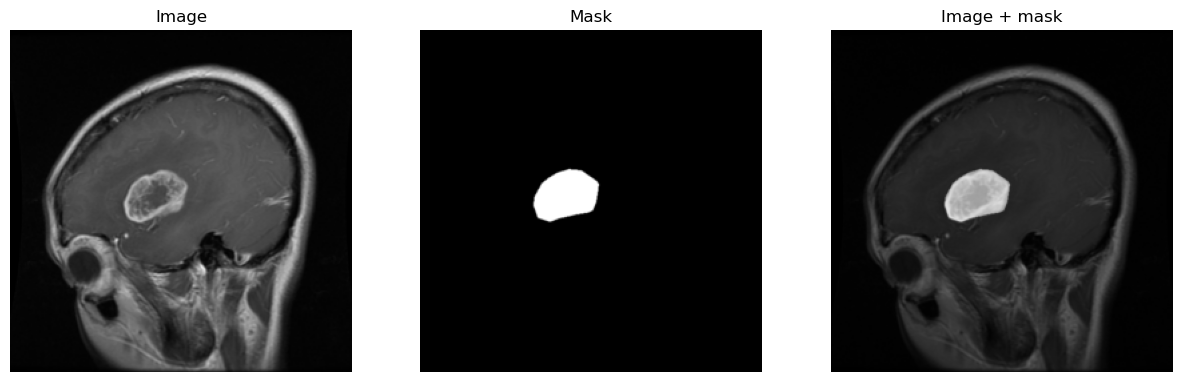

In [4]:
show_sample(image.squeeze(0), mask.squeeze(0))

## Load trained model
Evaluate trained model with a sample image

In [5]:
unet = UNet(in_channels=3, out_channels=1)

In [6]:
unet.eval()
output = unet(image)
print("Output min/max:", output.min().item(), output.max().item())

Output min/max: 0.0943150669336319 0.11695289611816406


In [7]:
output_sigmoid = torch.sigmoid(output)
print("Output sigmoid min/max:", output_sigmoid.min().item(), output_sigmoid.max().item())

Output sigmoid min/max: 0.5235612988471985 0.5292049646377563


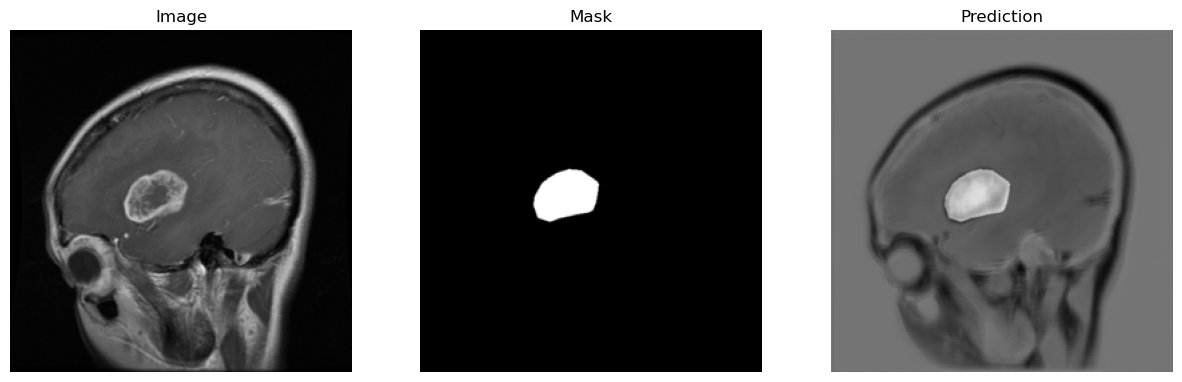

In [8]:
show_sample(image.squeeze(0), mask.squeeze(0), output_sigmoid.squeeze(0).detach())

## Load trained model

In [9]:
unet.load_state_dict(torch.load("./models/unet_14_03.pth", weights_only=True))

<All keys matched successfully>

In [10]:
unet.eval()
output = unet(image)
print("Output min/max:", output.min().item(), output.max().item())

Output min/max: -68.08611297607422 14.481195449829102


In [11]:
output_sigmoid = torch.sigmoid(output)
print("Output sigmoid min/max:", output_sigmoid.min().item(), output_sigmoid.max().item())

Output sigmoid min/max: 2.695112133780002e-30 0.9999995231628418


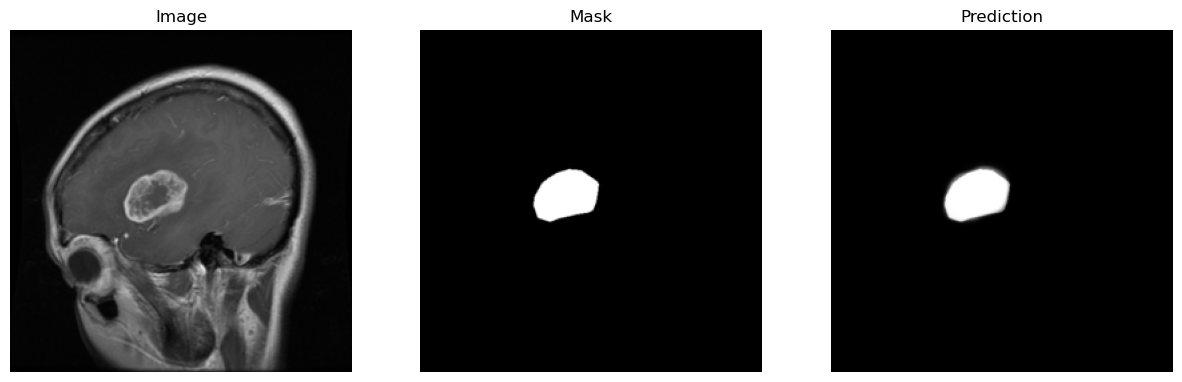

In [12]:
show_sample(image.squeeze(0), mask.squeeze(0), output_sigmoid.squeeze(0).detach())

In [13]:
from torchmetrics.classification import Dice
import numpy as np

In [14]:
dice_metric = Dice(num_classes=2, average="micro")

In [15]:
dice_metric(output_sigmoid.int(), mask.int()).item()

0.9803619384765625

In [16]:
def dice_score(preds, targets, threshold=0.5, eps=1e-7):
    """Calcula el coeficiente de Dice."""
    preds = (preds > threshold)
    targets = targets  # Asegurar que targets también es float
    intersection = (preds * targets).sum()
    return (2. * intersection + eps) / (preds.sum() + targets.sum() + eps)
print("Dice score:", dice_score(output_sigmoid, mask))
print("Dice metric:", dice_metric(output_sigmoid.int(), mask.int()))

Dice score: tensor(0.9429)
Dice metric: tensor(0.9804)


In [17]:
targets = torch.tensor([[[[0, 0], [0, 0]]]], dtype=torch.float32)
targets2 = torch.tensor([[[[0, 0], [0, 0]]]], dtype=torch.float32)
print(dice_score(targets2, targets))  # Debe ser 1.0
print(dice_metric(targets2.int(), targets.int()))
print(dice_score(mask, mask))

tensor(1.)
tensor(1.)
tensor(0.9822)


In [18]:
targets.shape

torch.Size([1, 1, 2, 2])

In [19]:
def dice_coef(groundtruth_mask, pred_mask, eps=1e-7):
    intersect = (groundtruth_mask * pred_mask).sum()
    total_sum = groundtruth_mask.sum() + pred_mask.sum() + eps
    # intersect = np.sum(pred_mask*groundtruth_mask)
    # total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    # dice = np.mean(2*intersect/total_sum)
    return (2. * intersect + eps) / total_sum

def dice_score2(preds, targets, threshold=0.5, eps=1e-7):
    """Calcula el coeficiente de Dice."""
    preds = (preds > threshold).float()
    targets = targets.float()
    intersection = (preds * targets).sum()
    return (2. * intersection + eps) / (preds.sum() + targets.sum() + eps)

print(dice_coef(mask, mask))

print(dice_score2(output_sigmoid, mask))

tensor(0.9758)
tensor(0.9429)
